# Approximation Policy Function in the MountainCar problem
## Neural network with one output (sigmoid)¶

Approximation of the policy function found by constructing the state graph

## Load from file

In [140]:
import math
import time
import gym
import numpy as np
import matplotlib.pyplot as plt
from   matplotlib import colors
import torch
import torch.nn as nn

pi = np.load("data/pi_smooth_thin.npy")

bins = pi.shape

low  = np.array([-1.2, -0.07], dtype=np.float32)
high = np.array([ 0.6,  0.07], dtype=np.float32)
step = (high-low)/bins

print("shape:", pi.shape, pi.dtype)
print("min, max:", np.min(pi), np.max(pi))
print("counts:", np.sum(pi == -1), np.sum(pi == 0), np.sum( pi == 1), np.sum( pi == 2))

shape: (5001, 5001) int64
min, max: -1 2
counts: 17060598 3522015 2131 4425257


## Visualization

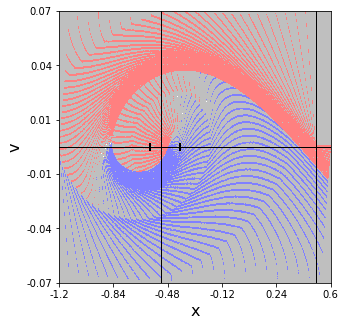

In [128]:
def plot(mat, title, d_ticks=1000, bins = (101,101)):
    def index(state):        
        indx = ((state - low)/step).astype(int)
        indx = np.clip(indx, (0,0), (bins[0]-1, bins[1]-1))
        return tuple( indx )

    g, m, x0   = index([0.5, 0.]), index([-math.pi/6, 0.]), np.array([ index([-0.6, 0.]), index([-0.4, 0.]) ])
    cmap = colors.ListedColormap(['gray', 'blue', 'white', 'red'])    
    
    plt.imshow(mat.T, interpolation='none', origin='lower', cmap= cmap, alpha=0.5)

    plt.title (title, {'fontsize': 16})
    plt.xlabel('x', {'fontsize': 16});         plt.ylabel('v', {'fontsize': 16}) 
    plt.axhline(g[1], c="black", linewidth=1); plt.axvline(g[0], c="black", linewidth=1)
    plt.axvline(m[0], c="black", linewidth=1)
    plt.axvline(x0[0][0], c="black", linewidth=2, ymin = 0.49, ymax = 0.51)
    plt.axvline(x0[1][0], c="black", linewidth=2, ymin = 0.49, ymax = 0.51)
    ticks = range(0, bins[0], d_ticks)
    plt.xticks( ticks, np.round(100*np.linspace(low[0], high[0], len(ticks)))/100 )
    plt.yticks( ticks, np.round(100*np.linspace(low[1], high[1], len(ticks)))/100 )
    
    
plt.figure(figsize=(5,5))
plot(pi, "", bins=bins)
plt.show()

## Create dataset

In [129]:
X, Y = [], []    
for ix in range(1, bins[0] - 1):
    for iv in range(1, bins[1] - 1):
        a = pi[ix, iv]
        if a != -1:                
            X.append( (low + (ix, iv)*step).tolist() )
            Y.append( float(pi[ix, iv])/2. )                          # !!!!! [0,2] -> [0,1]
    print(f"\r {100.*ix/bins[0]: .0f}%", end="")
print(" ... created")
    
X, Y = torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32).view(-1,1)         

print(X[-3:])
print(Y[-3:])

print(torch.min(Y), torch.max(Y), len(Y), torch.sum(Y == 1.), torch.sum( Y == 0.))

  100% ... created
tensor([[0.5993, 0.0009],
        [0.5993, 0.0009],
        [0.5993, 0.0010]])
tensor([[1.],
        [1.],
        [1.]])
tensor(0.) tensor(1.) 7949238 tensor(4425093) tensor(3522014)


In [130]:
data = torch.cat([X, Y], 1)
np.save("data/data_XY", data.numpy())
del data

In [132]:
data = np.load("data/data_XY.npy")
X, Y = data[:,0:2], data[:,2:]
X, Y = torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32).view(-1,1)         
print(torch.min(Y), torch.max(Y), len(Y), torch.sum(Y == 1.), torch.sum( Y == 0.))

tensor(0.) tensor(1.) 7949238 tensor(4425093) tensor(3522014)


## Create divice

In [80]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(gpu)

cuda:0


## Network architecture

In [134]:
neurons = [2, 32, 64, 1]
layers  = [] 
for i in range(len(neurons)-1):
    layers.append( nn.Linear(neurons[i], neurons[i+1]) )
    layers.append( nn.Sigmoid() )

model = nn.Sequential( *layers ) 
model.to(gpu) 

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=32, out_features=64, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=64, out_features=1, bias=True)
  (5): Sigmoid()
)

## Obtaining a policy matrix from a neural network

In [125]:
def table(bins = (101, 101)):    
    res = np.empty(bins)
    step = (high-low)/bins
    indx = torch.cartesian_prod(torch.arange(0, bins[0]), torch.arange(0, bins[1]))
    
    X = torch.tensor(low, dtype = torch.float32) + indx*torch.tensor(step, dtype = torch.float32)        
    
    with torch.no_grad():
        X = X.to(gpu)
        Y = model.to(gpu)(X).cpu()        
    
    Y = (2*Y).round().view(bins[0], bins[1]).numpy()
    return Y

model calc torch.Size([1002001, 2])
(1001, 1001)


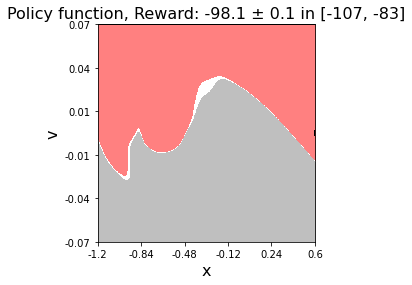

In [126]:
plt.figure(figsize=(10,10))
res = table( (1001, 1001) )
plot(res, 'Policy function, Reward: -98.1 ± 0.1 in [-107, -83]', d_ticks=100, bins = (1001, 1001))
plt.show()

## Learning

In [136]:
loss      = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(),   lr=0.1, momentum=0.8) 
#optimizer = torch.optim.Adam(model.parameters(), lr=0.1 )

X = X.to(gpu)
Y = Y.to(gpu)
print(X.device, Y.device)

cuda:0 cuda:0


In [137]:
def fit(model, X,Y, batch_size=1000, train=True):          
    model.train(train)                                   # important for Dropout, BatchNorm
    sumL, sumA, numB = 0, 0, int( len(X)/batch_size )    # error, accuracy, batches
       
    idx = torch.randperm( len(X) ).to(gpu)               # mix index list
    X, Y = X[idx], Y[idx]      

    for i in range(0, numB*batch_size, batch_size):          
        xb, yb = X[i: i+batch_size],  Y[i: i+batch_size]                                 
              
        y = model(xb)                                    # direct distribution
        L = loss(y, yb)                                  # calculate the loss
  
        if train:                                        # in learning mode
            optimizer.zero_grad()                        # reset the gradients        
            L.backward()                                 # calculate gradients            
            optimizer.step()                             # adjusting parameters
                                     
        sumL += L.item()                                 # total error (item from graph)
        sumA += (y.round() == yb).float().mean().item()  # class definition accuracy
         
    return sumL/numB,  sumA/numB                         # mean error and accuracy


    
def plot_fit(history):
    data = np.array(history)
    
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)        
    plt.xlabel('epoch');  plt.ylabel('loss');
    plt.plot(data[:,0], data[:,1])
    
    plt.subplot(1, 3, 2)        
    #plt.ylim(0.9, 1.); 
    plt.xlabel('epoch');  plt.ylabel('acc');
    plt.plot(data[:,0], data[:,2])

    plt.subplot(1, 3, 3)        
    res = table( (1001, 1001) )
    plot(res, '', d_ticks=100, bins = (1001, 1001))

    plt.show()    

before:      loss: 0.73604 accuracy: 0.4431
epoch:    10 loss: 0.03132 accuracy: 0.9909   17.97smodel calc torch.Size([1002001, 2])


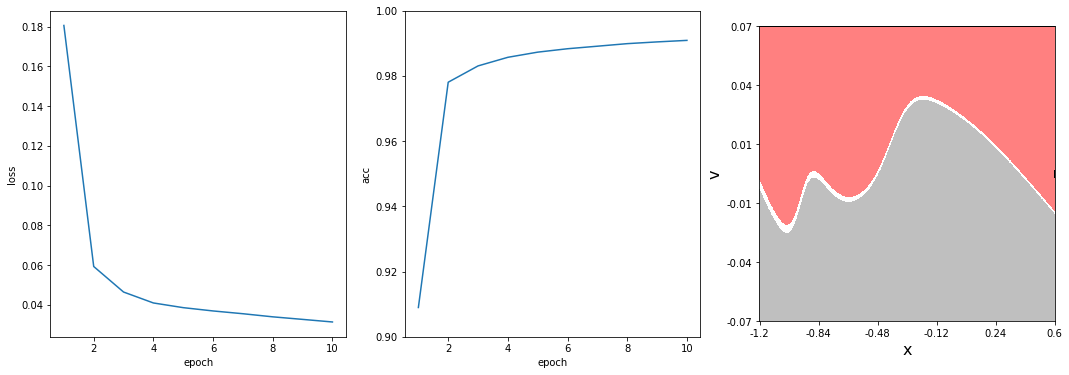

epoch:    12 loss: 0.02871 accuracy: 0.9916   17.05s

KeyboardInterrupt: 

In [138]:
model.to(gpu)
print( "before:      loss: %.5f accuracy: %.4f" %  fit(model, X,Y, train=False) )
 
beg = time.process_time()
history = []

epochs = 1000                                              # number of epochs
for epoch in range(1, epochs+1):                                
    L, A = fit(model, X, Y, batch_size=500)                 # one epoch
    history.append((epoch, L, A))
       
    if epoch % 1 == 0 or epoch == epochs:  
        print(f"\repoch: {epoch:5d} loss: {L:.5f} accuracy: {A:.4f}   {time.process_time()-beg:.2f}s", end="")   
        beg = time.process_time()
        
    if epoch % 10 == 0:
        plot_fit(history)
 

## Testing a neural network on a real environment

In [99]:
def test(model, episodes = 1000, ticks=200, level = 0.05):
    env = gym.make("MountainCar-v0")
    rews = []
    for episode in range(episodes):
        obs =  env.reset()
        tot = 0
        for _ in range(ticks):
            with torch.no_grad():
                #x = 2.*(torch.tensor(obs, dtype=torch.float32) - low)/(high-low) - 1.
                x = torch.tensor(obs, dtype=torch.float32)
                y = model(x)
            
            if   y > 0.5 + level:
                action = 2
            elif y < 0.5 - level:
                action = 0
            else:
                action = 1            

            obs, rew, done, _ = env.step(action)
            tot += rew

            if done:
                break

        rews.append(tot)
        if episode and episode % 100 == 0:
            mean, std = np.mean(rews), np.std(rews)
            print(f"\r{episode:5d}:  Reward: {mean:7.2f} ± {std/len(rews)**0.5:.1f}, std: {std:.0f}, min: {np.min(rews):.0f}  max: {np.max(rews):.0f}", end="")  

    mean, std = np.mean(rews), np.std(rews)
    print(f"\r{episode:5d}:  Reward: {mean:7.2f} ± {std/len(rews)**0.5:.1f}, std: {std:.0f}, min: {np.min(rews):.0f}  max: {np.max(rews):.0f}")  
            
    
test(model.cpu(), level = 0.0)

  999:  Reward:  -98.37 ± 0.2, std: 7, min: -106  max: -83


## Save net

In [ ]:
import datetime
  
state = {'info':      "MountainCar Reward:  -98.27 ± 0.1, std: 7, [-108, -83]",            # описание
         'date':      datetime.datetime.now(),   # дата и время
         'model':     str(model),
         'state' :    model.state_dict(),        # параметры модели
        } 
 
torch.save(state, 'MountainCar_2_128_128_1.98.2.pt')                    # сохраняем файл